In [69]:
%load_ext autoreload
%autoreload 2

In [70]:
import sys
import pathlib

sys.path.append(str(pathlib.Path().cwd().parent))

In [71]:
from typing import Tuple

from load_dataset import Dataset
from plotting import plot_ts

dataset = Dataset('../data/dataset/')

### В чем заключаются недостатки полносвязных сетей?
* невозможность улавливать временные закономерности в контексте предыдущих точек (архитектурное ограничение)
* фиксированный размер входных данных
* фиксированный размер выходных данных

### Область применимости рекуретных сетей для задачи анализа временных рядов
* большое количество экзогенных признаков, имеющих сложную нелинейную зависимость с целевым рядом
* очень сложная временная структура имеющая наложение разных сезонных и цикличных паттернов
* ряды с часто меняющимся паттерном, или большим количеством аномалий
* когда есть необходимость в нефиксированной длине входных и выходных данных (например многомерные ряды, где для разных компонент хочется предоставить разное количество лагов) 

### Особенности подготовки данных - необходима нормализация данных, иначе сеть будет плохо сходиться и медленно обучаться.

In [107]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [108]:
data = np.array(range(0, 100, 10)).reshape(-1, 1)

In [109]:
scaler = MinMaxScaler((0, 1))

In [110]:
scaler.fit(data)

MinMaxScaler()

In [111]:
transformed = scaler.transform(data)

In [113]:
transformed

array([[0.        ],
       [0.11111111],
       [0.22222222],
       [0.33333333],
       [0.44444444],
       [0.55555556],
       [0.66666667],
       [0.77777778],
       [0.88888889],
       [1.        ]])

In [115]:
inverse = scaler.inverse_transform(transformed)

In [116]:
inverse

array([[ 0.],
       [10.],
       [20.],
       [30.],
       [40.],
       [50.],
       [60.],
       [70.],
       [80.],
       [90.]])

### Особенность подготвки данных - обработка последовательностей разной длины.

In [80]:
from keras.preprocessing.sequence import pad_sequences

In [118]:
sequences = [
    [1, 2, 3, 4],
    [3, 4, 5],
    [5, 6],
    [3]
]

In [82]:
pad_sequences(sequences, padding='pre')

array([[1, 2, 3, 4],
       [0, 3, 4, 5],
       [0, 0, 5, 6],
       [0, 0, 0, 3]], dtype=int32)

In [83]:
pad_sequences(sequences, padding='post')

array([[1, 2, 3, 4],
       [3, 4, 5, 0],
       [5, 6, 0, 0],
       [3, 0, 0, 0]], dtype=int32)

In [84]:
pad_sequences(sequences, maxlen=2)

array([[3, 4],
       [4, 5],
       [5, 6],
       [0, 3]], dtype=int32)

In [85]:
pad_sequences(sequences, maxlen=2, truncating='post')

array([[1, 2],
       [3, 4],
       [5, 6],
       [0, 3]], dtype=int32)

### Какие архитектуры lstm нас интересуют в контексте временных рядов?
* one-to-one - предсказание следующей точки по предыдущей - нет
* one-to-many - предсказание следующих N точeк про предыдущей - нет
* many-to-one - one-step-ahead предсказание - в некоторой степени
* many-to-many -  предсказание вектора из следующих m точек по предыдущим n точкам - наибольший интерес

### Простая LSTM сеть

In [119]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [120]:
ts = dataset['daily-min-temperatures.csv']

<AxesSubplot:xlabel='1981-01-01'>

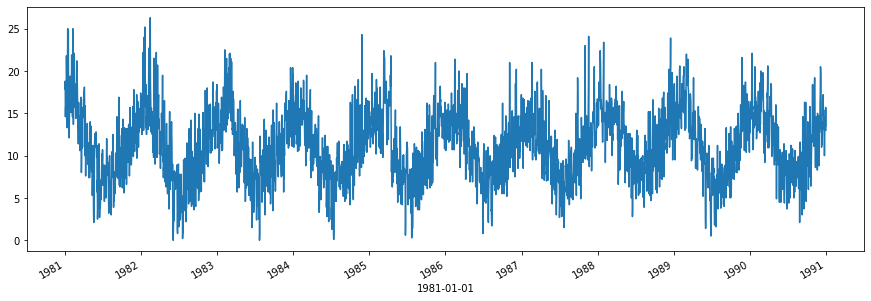

In [121]:
ts.plot(figsize=(15, 5))

In [136]:
def transform_into_matrix(ts: pd.Series, num_lags: int) -> Tuple[np.array]:
    """
    Transforms time series into lags matrix to allow
    applying supervised learning algorithms

    Parameters
    ------------
    ts
        Time series to transform
    num_lags
        Number of lags to use

    Returns
    --------
        train, test: np.arrays of shapes (ts-num_lags, num_lags), (num_lags,)
    """

    ts_values = ts.values
    data = {}
    for i in range(num_lags + 1):
        data[f'lag_{num_lags - i}'] = np.roll(ts_values, -i)

    lags_matrix = pd.DataFrame(data)[:-num_lags]
    lags_matrix.index = ts.index[num_lags:]

    return lags_matrix.drop('lag_0', axis=1).values, lags_matrix['lag_0'].values

In [137]:
NUM_LAGS = 14
X, y = transform_into_matrix(ts, NUM_LAGS)

In [138]:
X[0]

array([17.9, 18.8, 14.6, 15.8, 15.8, 15.8, 17.4, 21.8, 20. , 16.2, 13.3,
       16.7, 21.5, 25. ])

In [139]:
X = X.reshape((X.shape[0], X.shape[1], 1))

In [140]:
X[0]

array([[17.9],
       [18.8],
       [14.6],
       [15.8],
       [15.8],
       [15.8],
       [17.4],
       [21.8],
       [20. ],
       [16.2],
       [13.3],
       [16.7],
       [21.5],
       [25. ]])

In [141]:
split_idx = int(len(X)*0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [142]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(NUM_LAGS, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [130]:
model.fit(X, y, epochs=100)

Epoch 1/100
114/114 [==============================] - 2s 5ms/step - loss: 36.8584
Epoch 2/100
114/114 [==============================] - 1s 5ms/step - loss: 6.1299
Epoch 3/100
114/114 [==============================] - 1s 5ms/step - loss: 5.6039
Epoch 4/100
114/114 [==============================] - 1s 5ms/step - loss: 5.9444
Epoch 5/100
114/114 [==============================] - 1s 5ms/step - loss: 5.8751
Epoch 6/100
114/114 [==============================] - 1s 5ms/step - loss: 5.8838
Epoch 7/100
114/114 [==============================] - 1s 5ms/step - loss: 5.9504
Epoch 8/100
114/114 [==============================] - 1s 5ms/step - loss: 5.8694
Epoch 9/100
114/114 [==============================] - 1s 5ms/step - loss: 5.8464
Epoch 10/100
114/114 [==============================] - 1s 5ms/step - loss: 5.8177
Epoch 11/100
114/114 [==============================] - 1s 5ms/step - loss: 5.9287
Epoch 12/100
114/114 [==============================] - 1s 5ms/step - loss: 5.7321
Epoch 13/100

114/114 [==============================] - 0s 4ms/step - loss: 5.4009
Epoch 100/100
114/114 [==============================] - 0s 4ms/step - loss: 5.1663


In [131]:
y_pred = model.predict(X_test)

<AxesSubplot:>

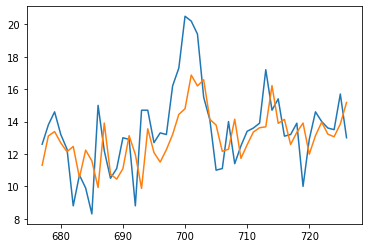

In [132]:
pd.Series(y_test.flatten())[-50:].plot()
pd.Series(y_pred.flatten())[-50:].plot()

In [133]:
### данный результат на самом деле не сильно лучше наивного предсказания

In [134]:
from sklearn.metrics import mean_squared_error as mse

In [135]:
mse(y_test.flatten(), y_pred.flatten())

4.564273825044342

### Stacked LSTM

#### Добавьте дополнительные скрытые слои в сеть (используйте return_sequences=True) и сравните качество

In [143]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(NUM_LAGS, 1), return_sequences=True))
model.add(LSTM(50, activation='relu', input_shape=(NUM_LAGS, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [144]:
model.fit(X_train, y_train, epochs=100, verbose=0)

KeyboardInterrupt: 

In [65]:
y_pred = model.predict(X_test)

<AxesSubplot:>

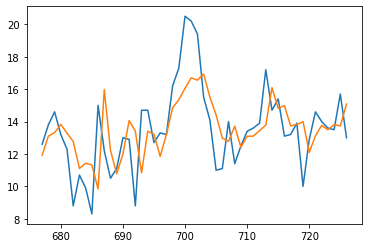

In [66]:
pd.Series(y_test.flatten())[-50:].plot()
pd.Series(y_pred.flatten())[-50:].plot()

### Bidirectional LSTM

#### Сделаем LSTM слой сети Bidirectional при помощи доп слоя Biderectional и сравним качество

In [145]:
from keras.layers import Bidirectional

model = Sequential()
# model.add(LSTM(50, activation='relu', input_shape=(NUM_LAGS, 1)))
model.add(Bidirectional(LSTM(50, activation='relu', input_shape=(NUM_LAGS, 1))))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [146]:
model.fit(X_train, y_train, epochs=10, verbose=0)

In [43]:
y_pred = model.predict(X_test)

### Seq2Seq LSTM - когда нужно сделать предсказание на несколько точек вперед

#### Подготовим данные

In [155]:
from typing import Tuple

def transform_ts_into_matrix(ts: pd.Series, num_lags_in: int, num_lags_out: int) -> Tuple[np.array, np.array]:
    """
    Данная функция должна пройтись скользящим окном по временному ряду и для каждых
    num_lags_in точек в качестве признаков собрать num_lags_out следующих точек в качестве таргета.
    
    Вернуть два np.array массива из X_train и y_train соответственно
    """
    sequence = ts.values
    X, y = list(), list()
    i = 0
    outer_idx = num_lags_out
    while outer_idx < len(sequence):
        inner_idx = i + num_lags_in
        outer_idx = inner_idx + num_lags_out
        X_, y_ = sequence[i:inner_idx], sequence[inner_idx:outer_idx]
        X.append(X_)
        y.append(y_)
        i += 1
    return np.array(X), np.array(y)

In [164]:
# получите X и y при помощи предыдущей функции и разбейте на трейн и тест 
NUM_LAGS_IN = 28
NUM_LAGS_OUT = 7

X, y = transform_ts_into_matrix(ts, NUM_LAGS_IN, NUM_LAGS_OUT)

In [166]:
X = X.reshape((X.shape[0], X.shape[1], 1))

In [167]:
X.shape

(3615, 28, 1)

In [157]:
# объявим енкодер
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(NUM_LAGS_IN, 1)))

In [158]:
# добавим промежуточный слой, преобразующий выход с енкодера для входного слоя в декодер
from keras.layers import RepeatVector
model.add(RepeatVector(NUM_LAGS_OUT))

In [159]:
# обьявим декодер
model.add(LSTM(50, activation='relu', return_sequences=True))

In [160]:
# обьявим выходной слой - размерность на выходе получается при помощи дополнительного слоя TimeDistributed
from keras.layers import TimeDistributed
model.add(TimeDistributed(Dense(1)))

#### Обучим модель и получим предсказание на тесте

In [161]:
model.compile(optimizer='adam', loss='mse')

In [163]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 100)               40800     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 7, 100)            0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 7, 50)             30200     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 7, 1)              51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [105]:
model.fit(X_train, y_train, epochs=10, verbose=0)

In [106]:
y_pred = model.predict(X_test)

### Пример с многомерным рядом.

In [179]:
ts_multi = pd.read_csv('../data/stability_index.csv', index_col='timestamp', parse_dates=True)

In [180]:
ts_multi.fillna(ts_multi.mean(), axis=0, inplace=True)

In [181]:
def transform_multi_ts_into_matrix(ts: pd.DataFrame, num_lags: int):
    """
    Данная функция должна пройтись скользящим окном по временному ряду
    и собрать в качестве признаков X np.array размерности (len(ts)-num_lags, n_dims, num_lags),
    а в качестве y np.array размерности (len(ts)-num_lags, n_dims),
    где n_dims - размерность многомерного ряда.
    
    То есть для всех компонент временного ряда мы должны взять num_lags предыдущих точек каждой компонент
    в качестве признаков и все компоненты текущей точки в качестве target
    """
    sequence = ts.values
    X, y = list(), list()
    i = 0
    end_i = num_lags
    while end_i < len(sequence): 
        seq_x, seq_y = sequence[i:end_i], sequence[end_i]
        X.append(seq_x)
        y.append(seq_y)
        i += 1
        end_i = i + num_lags
    return np.array(X), np.array(y)

In [182]:
X[0]

array([[205.,  92.,  63.,  55.,  26.,  27.,  20.,  34., 155.],
       [173.,  97.,  69.,  44.,  31.,  22.,  41.,  26., 182.],
       [145.,  83.,  73.,  58.,  40.,  25.,  31.,  19., 167.],
       [ 84.,  60.,  53.,  39.,  32.,  31.,  19.,  15., 102.],
       [117.,  77.,  40.,  53.,  33.,  29.,  21.,  30., 160.],
       [112.,  59.,  66.,  50.,  24.,  29.,  19.,  23., 145.],
       [119.,  64.,  53.,  41.,  32.,  29.,  29.,  22., 140.],
       [105.,  44.,  44.,  42.,  28.,  19.,  27.,  11., 142.],
       [106.,  36.,  49.,  33.,  19.,  30.,  23.,  20., 115.],
       [ 72.,  46.,  32.,  26.,  15.,  25.,  20.,  17.,  85.],
       [ 61.,  32.,  23.,  14.,  15.,  19.,   9.,   8.,  69.],
       [ 53.,  26.,  13.,  21.,  11.,  12.,   6.,   6.,  55.],
       [ 32.,  21.,  11.,   9.,   6.,   7.,   5.,   7.,  58.],
       [ 16.,  23.,  11.,   5.,   9.,   6.,   9.,  11.,  30.]])

In [188]:
NUM_LAGS = 14
N_DIMS = ts_multi.shape[1]
X, y = transform_multi_ts_into_matrix(ts_multi, NUM_LAGS)

In [184]:
X[0].shape

(14, 9)

In [185]:
# объявим енкодер
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(NUM_LAGS, N_DIMS)))

In [186]:
# добавим промежуточный слой, преобразующий выход с енкодера для входного слоя в декодер
from keras.layers import RepeatVector
model.add(RepeatVector(N_DIMS))

In [78]:
# обьявим декодер
model.add(LSTM(50, activation='relu', return_sequences=True))

In [79]:
# обьявим выходной слой - размерность на выходе получается при помощи дополнительного слоя TimeDistributed
from keras.layers import TimeDistributed
model.add(TimeDistributed(Dense(1)))

In [81]:
model.compile(optimizer='adam', loss='mse')

In [83]:
model.fit(X, y, epochs=50)

Epoch 1/50
130/130 [==============================] - 1s 9ms/step - loss: 4337.5293
Epoch 2/50
130/130 [==============================] - 1s 10ms/step - loss: 3359.5718
Epoch 3/50
130/130 [==============================] - 1s 11ms/step - loss: 2346.5215
Epoch 4/50
130/130 [==============================] - 1s 11ms/step - loss: 1834.7770
Epoch 5/50
130/130 [==============================] - 1s 9ms/step - loss: 1693.2955
Epoch 6/50
130/130 [==============================] - 1s 10ms/step - loss: 1496.0602
Epoch 7/50
130/130 [==============================] - 1s 10ms/step - loss: 1387.5758
Epoch 8/50
130/130 [==============================] - 1s 11ms/step - loss: 1265.3087
Epoch 9/50
130/130 [==============================] - 1s 9ms/step - loss: 1505.0157
Epoch 10/50
130/130 [==============================] - 1s 9ms/step - loss: 1514.8870
Epoch 11/50
130/130 [==============================] - 1s 8ms/step - loss: 1301.9706
Epoch 12/50
130/130 [==============================] - 1s 9ms/step -